**Approach - <br>- Data Reading and Understanding<br>- Preprocessing => removal of punctuations, numbers, lemmatization, fixing contractions, spelling correction<br> - Pretrained embeddings => glove embeddings https://nlp.stanford.edu/data/glove.twitter.27B.zip and emoji embeddings https://github.com/MirunaPislar/emoji2vec/tree/master/models <br>- Models => LogisticRegression, SVM, RandomForestClassifier**

In [3]:
#download glove embeddings
import urllib.request
import zipfile

urllib.request.urlretrieve("https://nlp.stanford.edu/data/glove.twitter.27B.zip", "glove.27B.zip")

with zipfile.ZipFile("glove.27B.zip","r") as zip_ref:
    zip_ref.extractall("./embeddings")

In [4]:
#All imports
from helpers import preprocessing
from helpers import models

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
#reload
import importlib
importlib.reload(preprocessing)
importlib.reload(models)

In [21]:
#constants
EMBEDDING_DIM = 100

### Step 1 - Data Reading and Understanding

In [7]:
#training data load and understanding
comments_df = pd.read_excel('./data/comments.xlsx', usecols=['comment','Sentiment' ])
comments_df.head()

,comment,Sentiment
0,hashtag hashtag hashtag hashtag hashtag hashta...,Neutral
1,send it pic _x000D_\n👁_x000D_\n👉 user,Neutral
2,if i get it on time maybe 😢,Mixed
3,gorgeous ❤,Positive
4,😍😍😍😍,Positive


In [8]:
comments_df.shape

(11856, 2)

In [9]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11856 entries, 0 to 11855
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    11856 non-null  object
 1   Sentiment  11856 non-null  object
dtypes: object(2)
memory usage: 185.4+ KB


In [10]:
comments_df['Sentiment'].value_counts(normalize=True)

Positive    0.813850
Neutral     0.127783
Negative    0.052800
Mixed       0.005567
Name: Sentiment, dtype: float64

### Step 2 - Data Preparation

In [11]:
#clean up and preprocessing using helper module "preprocessing"
def prepare_data(df, is_train):
  processed_df = preprocessing.preprocess_data(df, 'comment')  
  processed_df = preprocessing.convert_emoticon(processed_df, 'spelling_corrected', False)
  processed_df['cleaned_comment'] = processed_df['emoticon_converted']

  if is_train:
    processed_df['target'] = processed_df['Sentiment'].map({"Neutral":0, "Positive":1, "Negative":2, "Mixed":3})

  return processed_df

In [12]:
train_processed_df = prepare_data(comments_df, True)
train_processed_df[['comment', 'cleaned_comment', 'target']].head()

,comment,cleaned_comment,target
0,hashtag hashtag hashtag hashtag hashtag hashta...,"[hashtag, hashtag, hashtag, hashtag, hashtag, ...",0
1,send it pic _x000d_\n👁_x000d_\n👉 user,"[send, it, picture, 👁, 👉, user]",0
2,if i get it on time maybe 😢,"[if, i, get, it, on, time, maybe, 😢]",3
3,gorgeous ❤,"[gorgeous, ❤]",1
4,😍😍😍😍,"[😍, 😍, 😍]",1


**Train Val split**

In [13]:
X = train_processed_df['cleaned_comment']
y = train_processed_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, train_size=0.9, random_state=100)

**Word Embeddings**

In [15]:
#load glove pretrained embeddings
pretrained_embeddings = dict()
with open('./embeddings/glove.twitter.27B.100d.txt','r',encoding='utf-8') as file_handle:
  for line in file_handle:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    pretrained_embeddings[word]=vector

In [17]:
#load emoji embeddings
emoji_embeddings = dict()
with open('./embeddings/emoji_embeddings_100d.txt','r',encoding='utf-8') as file_handle:
  for line in file_handle:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emoji_embeddings[word]=vector

In [19]:
#helper function to convert a comment to its embedding vector representation
def sent_vec(comment):
  sent_emb = np.zeros(EMBEDDING_DIM)
  ctr = 1
  for token in comment:    
    if token in pretrained_embeddings:
      sent_emb += pretrained_embeddings[token]
      ctr += 1
    elif token in emoji_embeddings:
      sent_emb += emoji_embeddings[token]
      ctr += 1
  sent_emb = sent_emb / ctr
  return sent_emb

In [22]:
#convert input text to embedding representation
X_train_vecs = []
for comment in X_train:    
  X_train_vecs.append(sent_vec(comment))

X_val_vecs = []
for comment in X_val:    
  X_val_vecs.append(sent_vec(comment))

### Step 3 - Model Building

**Models grid search and execution uses helper module - models**

**Model 1 - Logistic Regression**

In [ ]:
#for logistic regression, hyper-params specified in module - models are enough, so empty containers here
pipeline_elements = []
hyper_params = dict()

grid_model = models.logistic_regression_grid(pipeline_elements, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 12 candidates, totalling 180 fits
train F1 Score: 0.8261909702752596


In [ ]:
#choose the parameter considering both train and test score to avoid overfitting
grid_results = pd.DataFrame({'C':grid_model.cv_results_.get('param_model__C').data, 
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results

,C,mean_train_score,mean_test_score
0,0.0001,0.723434,0.723246
1,0.001,0.750102,0.748311
2,0.01,0.779535,0.777399
3,0.1,0.811149,0.806470
4,0.5,0.826745,0.818377
5,1,0.829019,0.819833
6,2,0.828562,0.818231
7,5,0.829244,0.818095
8,10,0.828426,0.817448
9,12,0.828610,0.817963


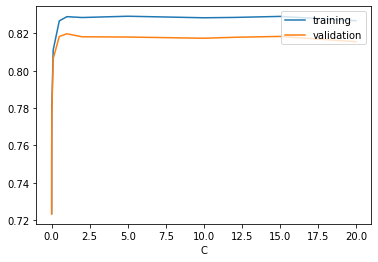

In [ ]:
plt.xlabel("C")
plt.plot(grid_results['C'], grid_results['mean_train_score'], label='training')
plt.plot(grid_results['C'], grid_results['mean_test_score'], label='validation')
plt.legend(loc='upper right')
plt.show()

**Training full dataset**

In [ ]:
#Training X_train on selected hyper param
final_model_params = {'C':1}
final_model = models.logistic_regression(X_train_vecs, y_train, final_model_params)

#evaluate on val
models.evaluate(final_model, X_val_vecs, y_val, "val")

train F1 Score: 0.8261909702752596
val F1 Score: 0.8251086555744926


**Model 2 - SVM**

**kernel - poly**

In [ ]:
#hyper-parameter tuning with kernel - poly, other params C degree gamma are already specified in module - models
pipeline_elements = []
hyper_params = {'model__kernel':['poly'], 'model__degree':[2,3]}

grid_model = models.svm_grid(pipeline_elements, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 36 candidates, totalling 540 fits
train F1 Score: 0.9355292538914176


In [ ]:
#choose params considering both train and test score to avoid over-fitting
grid_results = pd.DataFrame({'C':grid_model.cv_results_.get('param_model__C').data, 
                             'degree':grid_model.cv_results_.get('param_model__degree').data,
                             'gamma':grid_model.cv_results_.get('param_model__gamma').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv', index=False)

In [ ]:
#Training X_train on kernel: poly and degree:3
final_poly_params = {'C':2,'degree':3,'gamma':'scale','kernel':'poly'}
final_poly_model = models.svm(X_train_vecs, y_train, final_poly_params)

#evaluate on val
models.evaluate(final_poly_model, X_val_vecs, y_val, "val")

train F1 Score: 0.9035547802555323
val F1 Score: 0.8764994234914795


**kernel - rbf**

In [ ]:
#hyper-params C and gamma are in module - models
pipeline_elements = []
hyper_params = {'model__kernel':['rbf']}

grid_model = models.svm_grid(pipeline_elements, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 18 candidates, totalling 270 fits
train F1 Score: 0.9200173148678702


In [ ]:
#select params to avoid overfitting
grid_results = pd.DataFrame({'C':grid_model.cv_results_.get('param_model__C').data,                              
                             'gamma':grid_model.cv_results_.get('param_model__gamma').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv', index=False)

In [ ]:
#Training X_train on kernel: rbf
final_rbf_params = {'C':5,'gamma':'scale','kernel':'rbf', 'degree':0}
final_rbf_model = models.svm(X_train_vecs, y_train, final_rbf_params)

#evaluate on val
models.evaluate(final_rbf_model, X_val_vecs, y_val, "val")

train F1 Score: 0.9048636841095083
val F1 Score: 0.8886638071466352


**kernel - sigmoid**

In [ ]:
pipeline_elements = []
hyper_params = {'model__kernel':['sigmoid']}

grid_model = models.svm_grid(pipeline_elements, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 18 candidates, totalling 270 fits
train F1 Score: 0.7906035515931717


In [ ]:
grid_results = pd.DataFrame({'C':grid_model.cv_results_.get('param_model__C').data,                              
                             'gamma':grid_model.cv_results_.get('param_model__gamma').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv', index=False)

In [ ]:
#Training X_train on kernel: sigmoid
final_sigmoid_params = {'C':5,'gamma':'auto','kernel':'sigmoid', 'degree':0}
final_sigmoid_model = models.svm(X_train_vecs, y_train, final_sigmoid_params)

#evaluate on val
models.evaluate(final_sigmoid_model, X_val_vecs, y_val, "val")

train F1 Score: 0.7906035515931717
val F1 Score: 0.7926967234404783


**Model 3 - Random Forest Classifier**

**Tuning hyper-parameters of RF in stages<br>- n_estimators and max_depth by initializing rest to a constant value<br> - tuning min_samples_split and min_samples_leaf**

In [ ]:
#Invoke gridsearch cv to tune important parameters like n_estimators and max_depth of tree keeping some values constant for other tree parameters
model = models.RandomForestClassifier(random_state=100, class_weight='balanced', max_features='sqrt',
                                      min_samples_split=50, min_samples_leaf=50, n_jobs=-1)
hyper_params = {'n_estimators':range(50,130,10), 'max_depth':range(3,12,1)} 

grid_model = models.gridsearch_cv(model, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 12 candidates, totalling 180 fits


In [ ]:
grid_results = pd.DataFrame({'max_depth':grid_model.cv_results_.get('param_max_depth').data, 
                             'estimators':grid_model.cv_results_.get('param_n_estimators').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv')

In [ ]:
#Based on grid results, max_depth=9 and number of estimators=90
model = models.RandomForestClassifier(random_state=100, class_weight='balanced', max_features='sqrt',
                                      max_depth=9, n_estimators=90, n_jobs=-1)
hyper_params = {'min_samples_split':range(50,200,20), 'min_samples_leaf':range(50,200,20)} 

grid_model = models.gridsearch_cv(model, hyper_params, X_train_vecs, y_train)

Fitting 15 folds for each of 64 candidates, totalling 960 fits


In [ ]:
grid_results = pd.DataFrame({'min_samples_split':grid_model.cv_results_.get('param_min_samples_split').data, 
                             'min_samples_leaf':grid_model.cv_results_.get('param_min_samples_leaf').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv')

In [ ]:
#Based on grid results, min_samples_split=90 and min_samples_leaf=50

#Training X_train on selected params
final_model_params = {'n_estimators':90, 'max_depth':9, 'min_samples_split':90, 'min_samples_leaf':50}
final_model = models.rf_classifier(X_train_vecs, y_train, final_model_params)

#evaluate on val
models.evaluate(final_model, X_val_vecs, y_val, "val")

train F1 Score: 0.8743296749745566
val F1 Score: 0.8665584569236727


### Step 4 - Test Prediction

In [25]:
test_df  = pd.read_excel( './data/Test.xlsx')
test_df.head()

,id,comment
0,1,ouuuu 😍😍
1,2,i copped sidechick and hustle baby 2.0
2,3,i have mask acne and acne scars with a normal ...
3,4,i'm disappointed that your brand is promoting...
4,5,😢 what a waste of products😢 but genuine art ❤


In [26]:
test_processed_df = prepare_data(test_df, False)
test_processed_df[['id','comment','cleaned_comment']].head()

,id,comment,cleaned_comment
0,1,ouuuu 😍😍,"[wow, 😍, 😍]"
1,2,i copped sidechick and hustle baby 2.0,"[i, copped, sidekick, and, hustle, baby]"
2,3,i have mask acne and acne scars with a normal ...,"[i, have, mask, acne, and, acne, scars, with, ..."
3,4,i'm disappointed that your brand is promoting...,"[i, am, disappointed, that, your, brand, is, p..."
4,5,😢 what a waste of products😢 but genuine art ❤,"[😢, what, a, waste, of, products, 😢, but, genu..."


**Using either of the above trained model to run predictions**

In [ ]:
X_test = test_processed_df['cleaned_comment']
X_test_vecs = []
for comment in X_test:    
  X_test_vecs.append(sent_vec(comment))
  y_test_pred = final_sigmoid_model.predict(X_test_vecs)

print(y_test_pred)

[1 0 2 2 3]
